# 생성적 적대 신경망(GAN) - Generative Adversarial Networks

## GAN을 사용한 MNIST

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Dropout, Input, Reshape, Flatten, UpSampling2D, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

import tensorflow as tf, numpy as np, matplotlib.pyplot as plt, sys, tqdm

In [2]:
# 데이터 로드
(X_train,_),(_,_) = mnist.load_data()
X_train.shape, X_train[0]

((60000, 28, 28),
 array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,

In [3]:
# 각 픽셀을 [-1,1]범위의 값을 갖도록 정규화
# (0-127.5)/127.5 = -1
# (255-127.5)/127.5 = 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train.shape, X_train[0]

((60000, 28, 28),
 array([[-1.        , -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        ],
        [-1.        , -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        ],
        [-1.        , -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        , -1.      

In [4]:
# 단순 다층 퍼셉트론을 사용하고, 이미지를 784크기의 평평한 벡터로 만들어 입력, 데이터 모양을 수정한다.
X_train = X_train.reshape(60000,784)
X_train.shape

(60000, 784)

In [5]:
# 생성기 모델 구축
# 입력크기 : 784, 출력크기 : 784
# Set the seed for reproducible result
np.random.seed(1000)
randomDim = 10

generator = Sequential()
generator.add(Dense(256, input_dim=randomDim))
generator.add(LeakyReLU(.2))
generator.add(Dense(512))
generator.add(LeakyReLU(.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(.2))
generator.add(Dense(784, activation='tanh'))

In [6]:
# 판별기 모델 구축
# 입력크기 : 784, 출력크기 : 단일비트(0 or 1)
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784))
discriminator.add(LeakyReLU(.2))
discriminator.add(Dropout(.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(.2))
discriminator.add(Dropout(.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(.2))
discriminator.add(Dropout(.3))
discriminator.add(Dense(1, activation='sigmoid'))

- 다음으로 생성기와 판별기를 함께 결합해 GAN을 구성한다.
- GAN에서는 trainable 인수를 False로 설정해 판별기 가중치를 고정시킨다.

In [7]:
discriminator.trainalbe = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)

- 이 둘을 훈련시키는 비결은 먼저 판별기를 따로 훈련시키는것
- 판별기의 손실함수로는 이진 교차 엔트로피(binary_crossentropy)를 사용
- 이후 판별기의 가중치를 동결하고, 결합된 GAN을 훈련
- 이 때 생성기가 훈련된다. 생성기의 손실 함수 또한 이진 교차 엔트로피(binary_crossentropy)이다.

In [8]:
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
gan.compile(loss='binary_crossentropy', optimizer=adam)

- 에폭마다 랜덤 노이즈 샘플을 먼저 생성기에 공급하면 생성기는 가짜 이미지를 만든다.
- 생성된 가짜 이미지와 실제 훈련 이미지를 특정 레이블과 함께 배치하고<br>
  이를 사용해 주어진 배치에서 먼저 판별기를 훈련시킨다.

In [9]:
dLosses = []
gLosses = []

# 각 배치에서 손실 도식화
def plotLoss(epoch):
    plt.figure(figsize=(10,8))
    plt.plot(dLosses, label='Discriminative loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/VanillaGAN/gan_loss_epoch_%d.png' %epoch)

# 생성된 MNIST 이미지 나열
def saveGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)
    
    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('images/VanillaGAN/gan_generated_image_epoch_%d.png' %epoch)

In [10]:
def train(epochs=1, batchSize=128):
    batchCount = int(X_train.shape[0] / batchSize)
    print('Epochs:', epochs)
    print('Batch size:', batchSize)
    print('Batches per epoch:', batchCount)
    
    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' %e, '-'*15)
        for _ in range(batchCount):
            # 랜덤 입력 노이즈와 이미지를 얻는다.
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]
            
            # 가짜 MNIST 이미지 생성
            generatedImages = generator.predict(noise)
            # np.shape(imageBatch), np.shape(generatedImages) 출력
            X = np.concatenate([imageBatch, generatedImages])
            
            # 생성된 것과 실제 이미지의 레이블
            yDis = np.zeros(2*batchSize)
            # 편파적 레이블 평활화
            yDis[:batchSize] = 0.9
            
            # 판별기 훈련
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)
            
            # 생성기 훈련
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)
        
        # 이 에폭의 최근 배치에서의 손실을 저장
        dLosses.append(dloss)
        gLosses.append(gloss)
        
        # 첫 에폭과 20에폭마다 이미지를 생성하여 저장
        if e == 1 or e % 20 == 0:
            saveGeneratedImages(e)
    
    # GAN이 학습하는 동안 생성기와 판별기의 모든 에폭의 손실을 도식화
    plotLoss(e)

Epochs: 200
Batch size: 128
Batches per epoch: 468
--------------- Epoch 1 ---------------
--------------- Epoch 2 ---------------
--------------- Epoch 3 ---------------
--------------- Epoch 4 ---------------
--------------- Epoch 5 ---------------
--------------- Epoch 6 ---------------
--------------- Epoch 7 ---------------
--------------- Epoch 8 ---------------
--------------- Epoch 9 ---------------
--------------- Epoch 10 ---------------
--------------- Epoch 11 ---------------
--------------- Epoch 12 ---------------
--------------- Epoch 13 ---------------
--------------- Epoch 14 ---------------
--------------- Epoch 15 ---------------
--------------- Epoch 16 ---------------
--------------- Epoch 17 ---------------
--------------- Epoch 18 ---------------
--------------- Epoch 19 ---------------
--------------- Epoch 20 ---------------
--------------- Epoch 21 ---------------
--------------- Epoch 22 ---------------
--------------- Epoch 23 ---------------
---------------

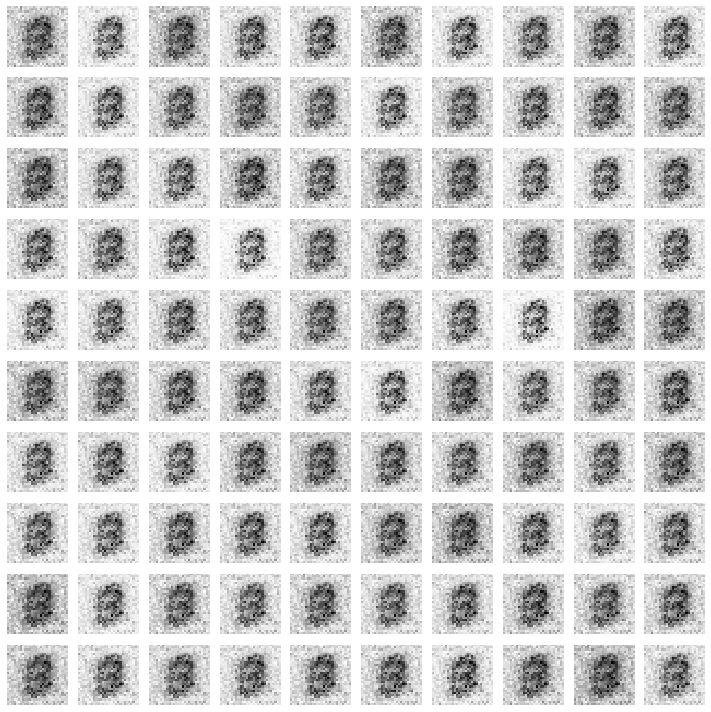

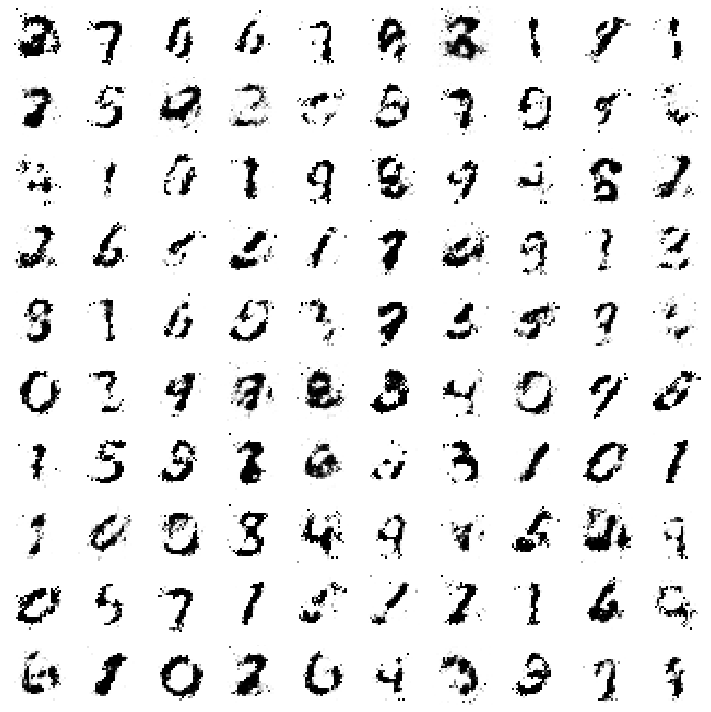

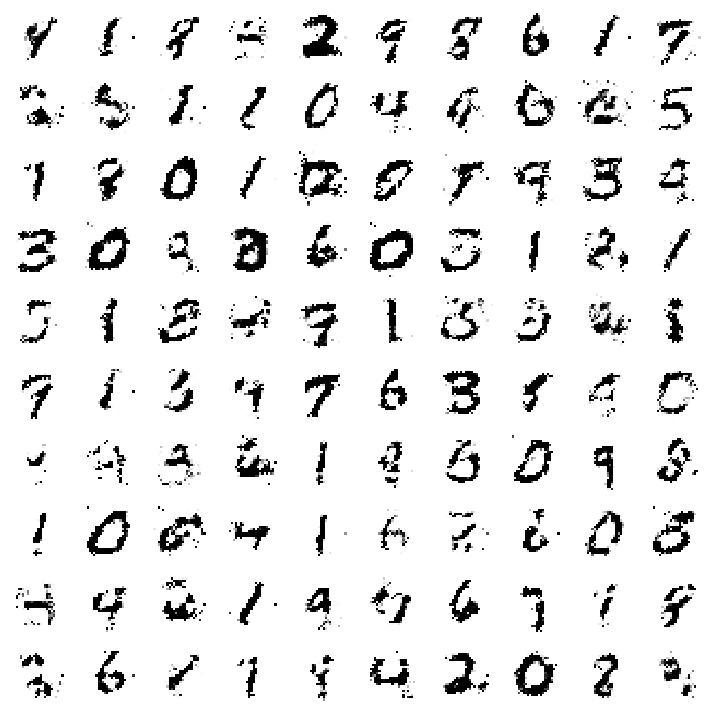

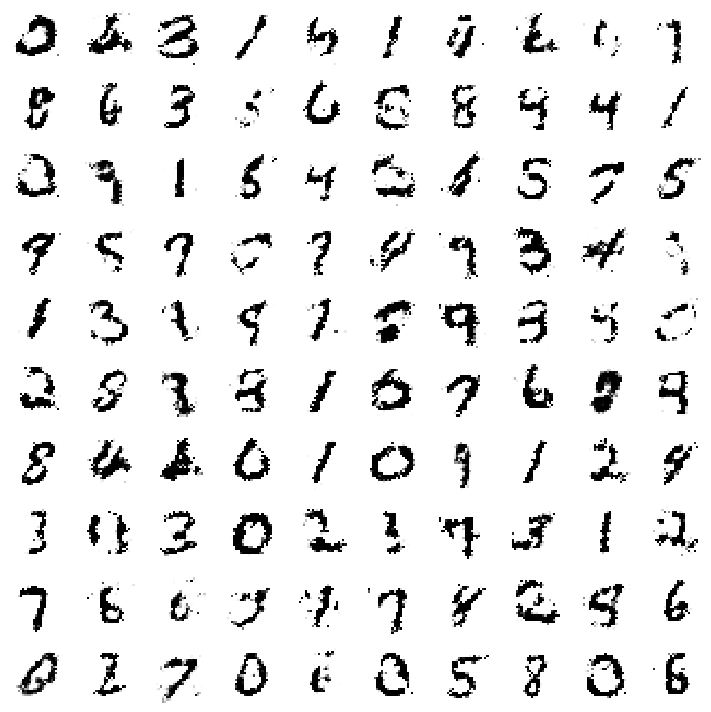

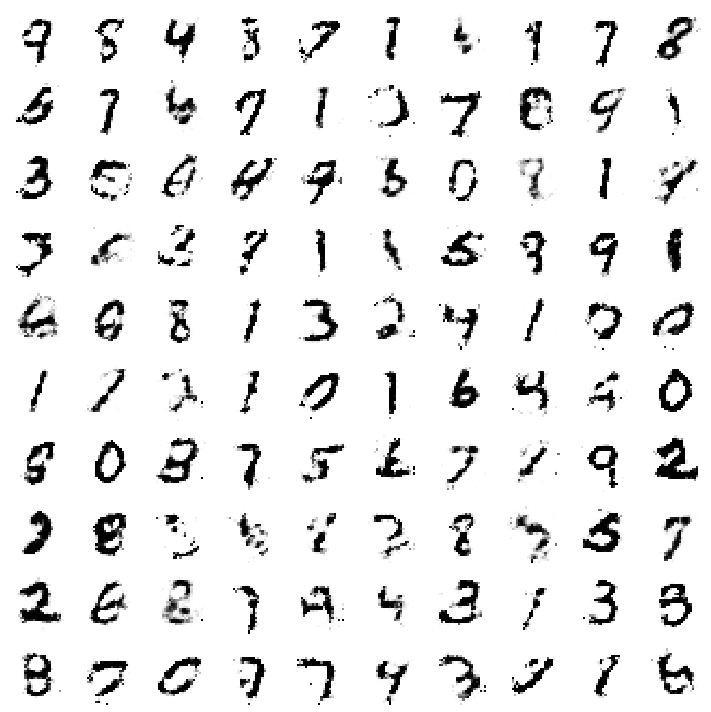

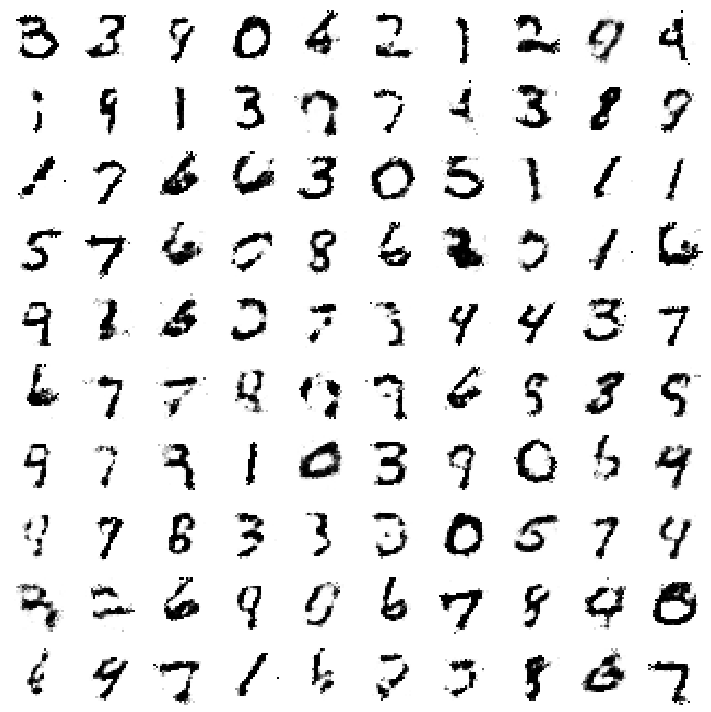

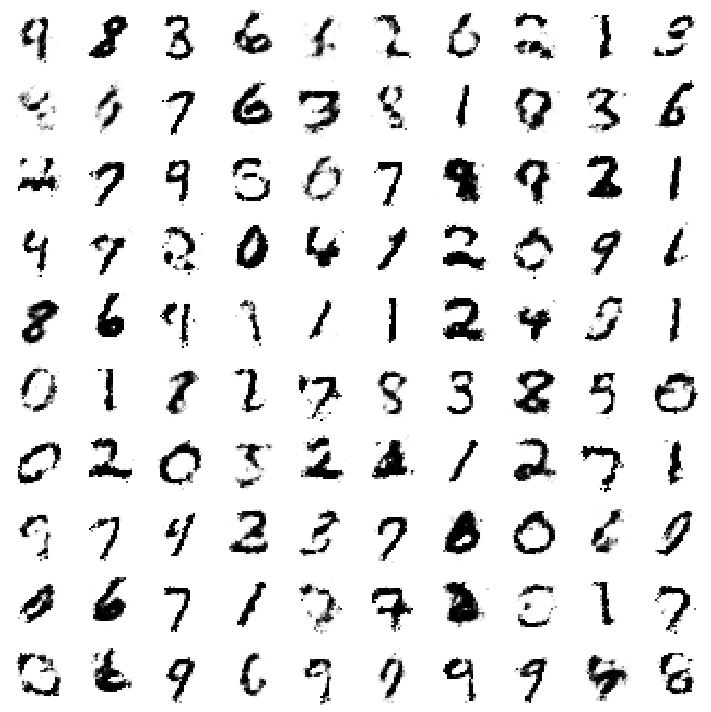

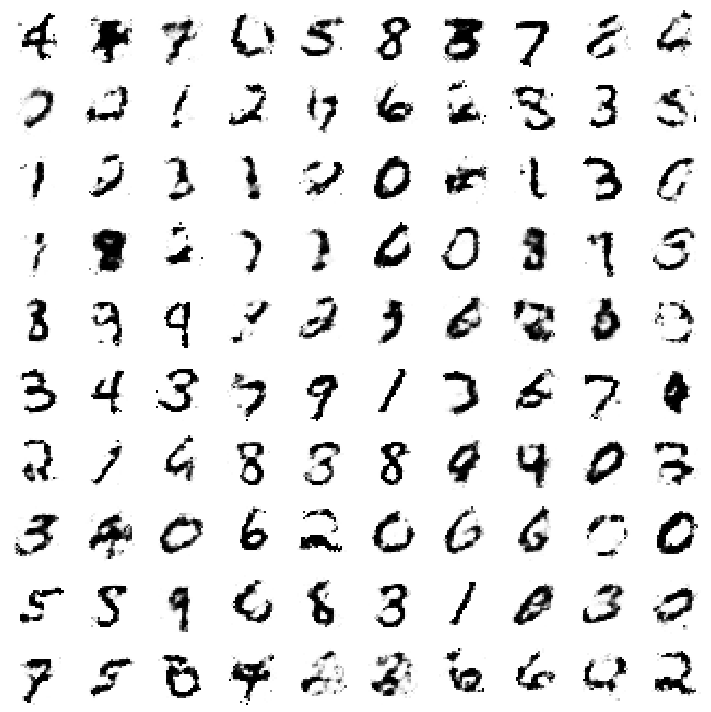

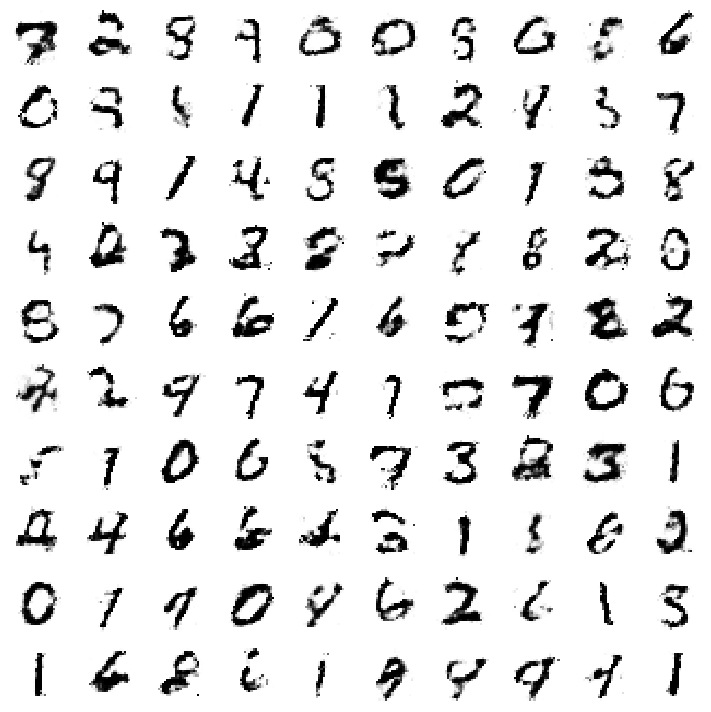

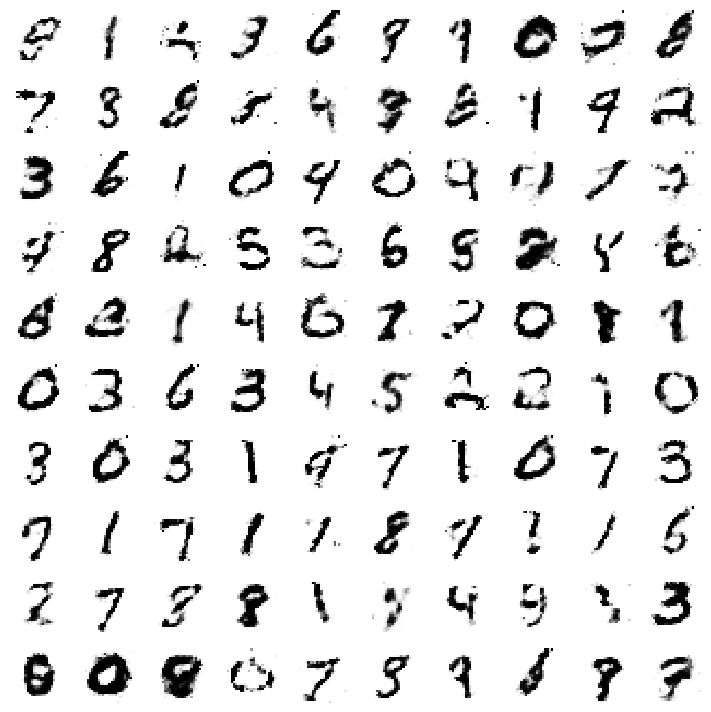

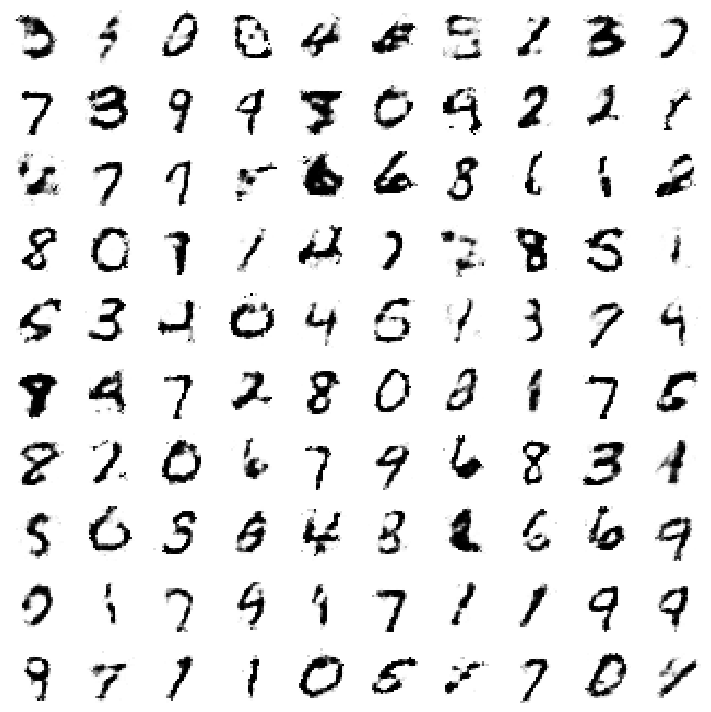

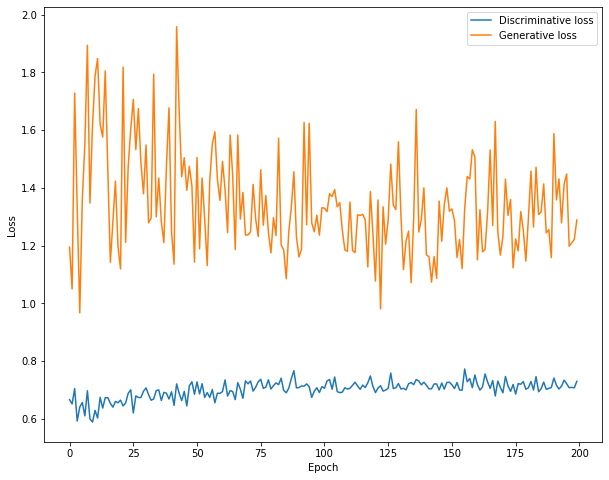

In [11]:
train(200,128)

## 심층 컨볼루션 GAN(DCGAN) - Deep Convolution Generative Adversarial Networks

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt, numpy as np, sys

# google colab 에서 코드를 돌린 후 저장 하고자하는 파일을 저장 할 때 사용
# 사용 : 1.해당 파일의 저장 코드를 먼저 돌려줌(model.save(filepath), model.save_weights(filepath), plt.savefig(filepath))
#       2.files.download(filepath) <-이 코드를 한번 더 입력
#from google.colab import files

In [2]:
dLosses = []
gLosses = []

class DCGAN():
        
    '''# 생성된 MNIST 이미지 나열
    def saveGeneratedImages(epoch, dim=(10, 10), figsize=(10, 10)):
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        generatedImages = self.generator.predict(noise)
        generatedImages = generatedImages.reshape(generatedImages, 28, 28)

        plt.figure(figsize=figsize)
        for i in range(generatedImages.shape[0]):
            plt.subplot(dim[0], dim[1], i+1)
            plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
            plt.axis('off')
        plt.tight_layout()'''
    
    def __init__(self, rows, cols, channels, z=100):
        # 입력 형태
        self.img_rows = rows
        self.img_cols = cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z
        
        optimizer = Adam(0.0002, 0.5)
        
        # 판별기 구축과 컴파일
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        # 생성기 구축
        self.generator = self.build_generator()
        
        # 생성기는 노이즈를 입력으로 받아 이미지를 생성한다.
        Z = Input(shape=(self.latent_dim,))
        img = self.generator(Z)
        
        # 결합된 모델에서는 생성기만 훈련한다.
        self.discriminator.trainable = False
        
        # 판별기는 생성된 이미지를 입력으로 받아 진위 여부를 판단한다.
        valid = self.discriminator(img)
        
        # 결합된 모델(생성기와 판별기를 쌓음)
        # 생성기를 훈련해 판별기를 속인다
        self.combined = Model(Z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    # 생성기 모델 구축
    def build_generator(self):
        model = Sequential()
        model.add(Dense(128 * 7 * 7, activation='relu', input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation('relu'))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation('relu'))
        model.add(Conv2D(self.channels, kernel_size=3, padding='same'))
        model.add(Activation('tanh'))
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)
    
    # 판별기 모델 구축
    def build_discriminator(self):
        model = Sequential()
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding='same'))
        model.add(LeakyReLU(alpha=.2))
        model.add(Dropout(.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=.8))
        model.add(LeakyReLU(alpha=.2))
        model.add(Dropout(.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
        model.add(BatchNormalization(momentum=.8))
        model.add(LeakyReLU(alpha=.2))
        model.add(Dropout(.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding='same'))
        model.add(BatchNormalization(momentum=.8))
        model.add(LeakyReLU(alpha=.2))
        model.add(Dropout(.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)
    
    def train(self, epochs, batch_size=128, save_interval=50):
        # 데이터셋 로드
        (X_train,_),(_,_) = mnist.load_data()
        
        # -1과 1 사이로 크기 조정
        X_train = X_train / 127.5 - 1
        X_train = np.expand_dims(X_train, axis=3)
        
        # 적대적 참의 정의
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        for epoch in range(epochs):
            # ----------
            # 판별기 훈련
            # ----------
            
            # 임의로 이미지의 반을 선택
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            
            # 노이즈를 샘플링해 새로운 이미지의 배치 생성
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            
            # 판별기 훈련(진짜는 1, 가짜는 0으로 분류)
            self.discriminator.trainalbe = True
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # ----------
            # 생성기 훈련
            # ----------
            
            # 생성기 훈련(판별기가 이미지를 진짜로 오인하기를 바란다)
            self.discriminator.trainalbe = False
            g_loss = self.combined.train_on_batch(noise, valid)
            
            # 진도 도식화
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %(epoch, d_loss[0], 100*d_loss[1], g_loss))
            
            # 이 에폭의 최근 배치에서의 손실을 저장
            dLosses.append(d_loss)
            gLosses.append(g_loss)
            
            # 저장 구간에서의 If => 생성된 이미지 저장
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
    
    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        
        # 이미지를 0 ~ 1 사이로 조정
        gen_imgs = 0.5 * gen_imgs + 0.5
        
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig('images/DCGAN/dcgan_mnist_%d.png' %epoch)
        #plt.savefig('dcgan_mnist_%d.png' %epoch)
        #files.download('dcgan_mnist_%d.png' %epoch)
        
    # 각 배치에서 손실 도식화
    def plotLoss(epochs=4000):
        plt.figure(figsize=(10,8))
        plt.plot(dLosses, label='Discriminative loss')
        plt.plot(gLosses, label='Generative loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig('images/DCGAN/dcgan_loss_epoch_%d.png' %epochs)
        #plt.savefig('dcgan_loss_epoch_%d.png' %epoch)
        #files.download('dcgan_mnist_%d.png' %epoch)

In [3]:
dcgan = DCGAN(28,28,1)
dcgan.train(epochs=5000, batch_size=256, save_interval=50)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 64)          0

KeyboardInterrupt: 

## CycleGAN

In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Model
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error

import os, time, matplotlib.pyplot as plt, numpy as np

In [6]:
dataset, metadata = tfds.load('cycle_gan/summer2winter_yosemite',
                             with_info=True, as_supervised=True)
train_A, train_B = dataset['trainA'], dataset['trainB']
test_A, test_B = dataset['testA'], dataset['testB']

In [7]:
# 하이퍼 파라미터(상수)지정
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
EPOCHS = 50
AUTOTUNE = tf.data.experimental.AUTOTUNE

- 신경망을 훈련시키기 전에 이미지를 정규화해야 함
- 더 나은 성능을 위해 이미지에 지터(jitter)를 추가할 수도 있다.

In [8]:
def normalize(input_image, label):
    input_image = tf.cast(input_image, tf.float32)
    input_image = (input_image / 127.5) - 1
    return input_image

In [9]:
train_A = train_A.map(normalize, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_B = train_B.map(normalize, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_A = test_A.map(normalize, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_B = test_B.map(normalize, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

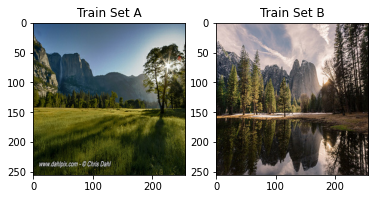

In [10]:
inpA = next(iter(train_A))
inpB = next(iter(train_B))

plt.subplot(121)
plt.title("Train Set A")
plt.imshow(inpA[0]*0.5 + 0.5)

plt.subplot(122)
plt.title("Train Set B")
plt.imshow(inpB[0]*0.5 + 0.5)

In [11]:
# 기본 컨볼루션 연산을 구행할 다운 샘플링 계층 정의
def downsample(filters, size=3, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2,
                             padding='same',
                             kernel_initializer=initializer,
                             use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())

    return result

# 이미지를 받아 전치 컨볼루션 연산을 구행할 업샘플링 계층 정의
def upsample(filters, size=3, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

# 충분한 심층 모델을 갖게 하는 레지듀얼 계층 정의
class ResnetIdentityBlock(tf.keras.Model):
    def __init__(self, kernel_size, filters):
        super(ResnetIdentityBlock, self).__init__(name='')
        filters1, filters2, filters3 = filters

        self.conv2a = tf.keras.layers.Conv2D(filters1, (1, 1))
        self.bn2a = tf.keras.layers.BatchNormalization()

        self.conv2b = tf.keras.layers.Conv2D(filters2, kernel_size, padding='same')
        self.bn2b = tf.keras.layers.BatchNormalization()

        self.conv2c = tf.keras.layers.Conv2D(filters3, (1, 1))
        self.bn2c = tf.keras.layers.BatchNormalization()

    def call(self, input_tensor, training=False):
        x = self.conv2a(input_tensor)
        x = self.bn2a(x, training=training)
        x = tf.nn.relu(x)

        x = self.conv2b(x)
        x = self.bn2b(x, training=training)
        x = tf.nn.relu(x)

        x = self.conv2c(x)
        x = self.bn2c(x, training=training)

        x += input_tensor
        return tf.nn.relu(x)

    
block1 = ResnetIdentityBlock(3, [512, 512, 512])
block2 = ResnetIdentityBlock(3, [512, 512, 512])
block3 = ResnetIdentityBlock(3, [512, 512, 512])


resnet = [block1, block2, block3]
print(block1(tf.zeros([1, 16, 16, 512])).shape)
print([x.name for x in block1.trainable_variables])

(1, 16, 16, 512)
['resnet_identity_block/conv2d/kernel:0', 'resnet_identity_block/conv2d/bias:0', 'resnet_identity_block/batch_normalization/gamma:0', 'resnet_identity_block/batch_normalization/beta:0', 'resnet_identity_block/conv2d_1/kernel:0', 'resnet_identity_block/conv2d_1/bias:0', 'resnet_identity_block/batch_normalization_1/gamma:0', 'resnet_identity_block/batch_normalization_1/beta:0', 'resnet_identity_block/conv2d_2/kernel:0', 'resnet_identity_block/conv2d_2/bias:0', 'resnet_identity_block/batch_normalization_2/gamma:0', 'resnet_identity_block/batch_normalization_2/beta:0']


In [12]:
# 생성기 구축
def Generator():
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4)
    ]
    
    up_stack = [
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4,
                                          strides=2,
                                          padding='same',
                                          kernel_initializer=initializer,
                                          activation='tanh')
    
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    x = inputs
    
    # 모델을 통해 다운샘플링
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
        
    for block in resnet:
        x = block(x)
        
    skips = reversed(skips[:-1])
    
    # 업샘플링과 스킵 연결 구현
    for up, skip in zip(up_stack, skips):
        concat = tf.keras.layers.Concatenate()
        x = up(x)
        x = concat([x, skip])
        
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

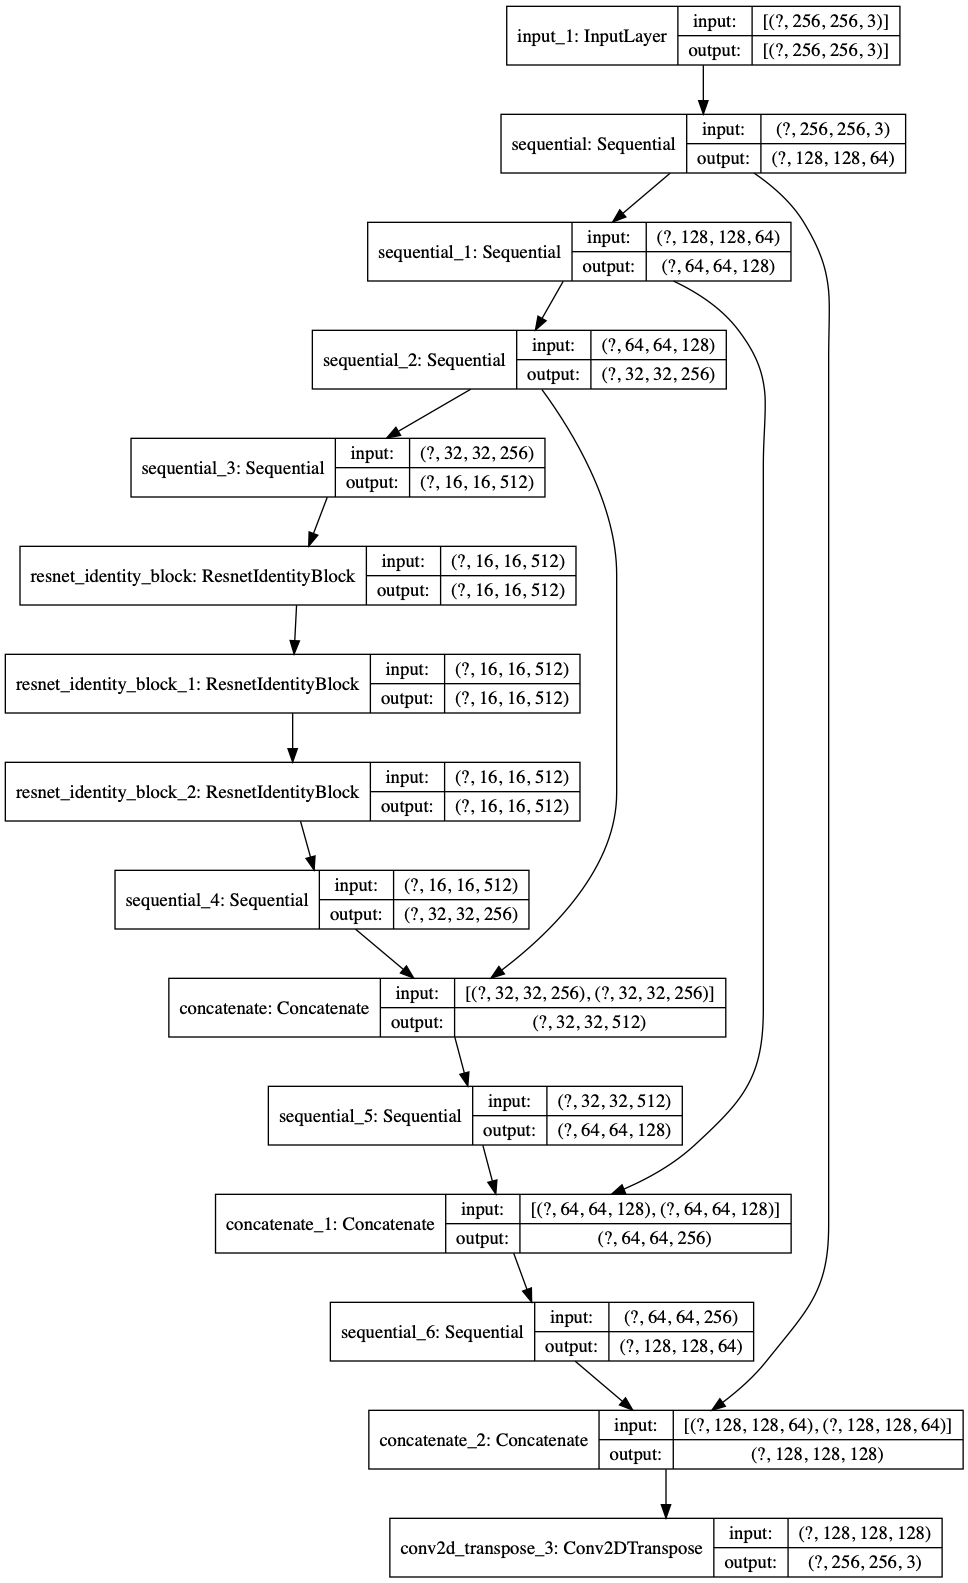

In [13]:
generator = Generator()
tf.keras.utils.plot_model(generator, 'model/CycleGAN/CycleGAN_Gen.png', show_shapes=True)

In [14]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 64, 128)  131584      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 32, 32, 256)  525312      sequential_1[0][0]               
______________________________________________________________________________________________

(1, 256, 256, 3) 0.5362119 0.46144173


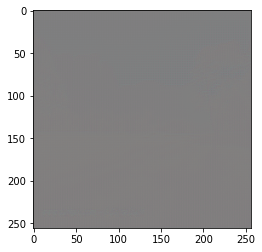

In [15]:
gen_output = generator(inpA, training=False)
gen_output = (gen_output + 1) / 2
plt.imshow(gen_output[0])
print(gen_output.shape,gen_output[0,...].numpy().max(), gen_output[0,...].numpy().min())

In [16]:
# 판별기 구축
def Discriminator():
    inputs = tf.keras.layers.Input(shape=[None,None,3])
    x = inputs
    g_filter = 64
    
    down_stack = [
        downsample(g_filter),
        downsample(g_filter * 2),
        downsample(g_filter * 4),
        downsample(g_filter * 8),
    ]
    
    for down in down_stack:
        x = down(x)
        
    last = tf.keras.layers.Conv2D(1, 4, strides=1, padding='same') #(bs, 30, 30, 1)
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

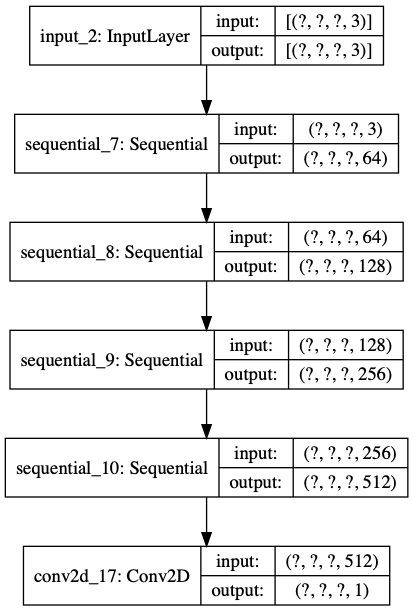

In [17]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, 'model/CycleGAN/CycleGAN_Dis.png', True)

In [18]:
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
sequential_7 (Sequential)    (None, None, None, 64)    1984      
_________________________________________________________________
sequential_8 (Sequential)    (None, None, None, 128)   74240     
_________________________________________________________________
sequential_9 (Sequential)    (None, None, None, 256)   295936    
_________________________________________________________________
sequential_10 (Sequential)   (None, None, None, 512)   1181696   
_________________________________________________________________
conv2d_17 (Conv2D)           (None, None, None, 1)     8193      
Total params: 1,562,049
Trainable params: 1,560,129
Non-trainable params: 1,920
_____________________________________________

In [19]:
# CyclaGAN 구성
discriminator_A = Discriminator()
discriminator_B = Discriminator()

generator_AB = Generator()
generator_BA = Generator()

In [20]:
# 손실 함수와 최적화기를 정의
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [21]:
@tf.function
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

In [22]:
optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

In [23]:
# 실제와 가짜 이미지 레이블용 플레이스홀더를 생성한다.
valid = np.ones((BATCH_SIZE, 16, 16, 1)).astype('float32')
fake = np.zeros((BATCH_SIZE, 16, 16, 1)).astype('float32')

- 이제 생성자와 판별기를 한 번에 한 쌍의 이미지로 일괄 처리하는 함수를 정의한다.
- 테이프 그래디언트의 도움으로 두 판별기와 두 생성기는 이 함수를 통해 학습된다.
- 두 판별기:discriminator_A,discriminator_B
- 두 생성기:generator_AB,generator_BA

In [24]:
@tf.function
def train_batch(imgs_A, imgs_B):
    with tf.GradientTape() as g, tf.GradientTape() as d_tape:
        fake_B = generator_AB(imgs_A, training=True)
        fake_A = generator_BA(imgs_B, training=True)
        
        logits_real_A = discriminator_A(imgs_A, training=True)
        logits_fake_A = discriminator_A(fake_A, training=True)
        dA_loss = discriminator_loss(logits_real_A, logits_fake_A)
        
        logits_real_B = discriminator_B(imgs_B, training=True)
        logits_fake_B = discriminator_B(fake_B, training=True)
        dB_loss = discriminator_loss(logits_real_B, logits_fake_B)
        d_loss = (dA_loss + dB_loss) / 2
        
        # 이미지를 원래 영역으로 다시 변환
        reconstr_A = generator_BA(fake_B, training=True)
        reconstr_B = generator_AB(fake_A, training=True)
        
        id_A = generator_BA(imgs_A, training=True)
        id_B = generator_AB(imgs_B, training=True)
        
        gen_loss = tf.math.reduce_sum([
            1 * tf.math.reduce_mean(mean_squared_error(logits_fake_A,valid)),
            1 * tf.math.reduce_mean(mean_squared_error(logits_fake_B,valid)),
            10 * tf.math.reduce_mean(mean_squared_error(reconstr_A,imgs_A)),
            10 * tf.math.reduce_mean(mean_squared_error(reconstr_B,imgs_B)),
            0.1 * tf.math.reduce_mean(mean_squared_error(id_A,imgs_A)),
            0.1 * tf.math.reduce_mean(mean_squared_error(id_B,imgs_B)),
        ])
        
    gradients_of_d = d_tape.gradient(d_loss, discriminator_A.trainable_variables + discriminator_B.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_d, discriminator_A.trainable_variables + discriminator_B.trainable_variables))
    
    gradients_of_generator = g.gradient(gen_loss, generator_AB.trainable_variables + generator_BA.trainable_variables)
    optimizer.apply_gradients(zip(gradients_of_generator, generator_AB.trainable_variables + generator_BA.trainable_variables))
    
    return dA_loss, dB_loss, gen_loss

In [25]:
# 모델의 가중치를 저장하고자 체크포인트를 정의함
checkpoint_dird_A = './checkpoint/CycleGAN/training_checkpointsd_A'
checkpoint_prefixd_A = os.path.join(checkpoint_dird_A, "ckpt_{epoch}")

checkpoint_dird_B = './checkpoint/CycleGAN/training_checkpointsd_B'
checkpoint_prefixd_B = os.path.join(checkpoint_dird_B, 'ckpt_{epoch}')

checkpoint_dirg_AB = './checkpoint/CycleGAN/training_checkpointsg_AB'
checkpoint_prefixg_AB = os.path.join(checkpoint_dirg_AB, "ckpt_{epoch}")

checkpoint_dirg_BA = './checkpoint/CycleGAN/training_checkpointsg_BA'
checkpoint_prefixg_BA = os.path.join(checkpoint_dirg_BA, "ckpt_{epoch}")

- 이제 모든 것을 결합하고 50에폭 동안 신경망을 훈련시킴
- 원 논문에서는 에폭수를 200으로 훈련시킴

In [26]:
def train(trainA_, trainB_, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for batch_i, (imgs_A, imgs_B) in enumerate(zip(trainA_, trainB_)):
            dA_loss, dB_loss, g_loss = train_batch(imgs_A, imgs_B)
            
            if batch_i % 1000 == 0:
                test_imgA = next(iter(test_A))
                test_imgB = next(iter(test_B))
                print ('Time taken for epoch {} batch index {} is {} seconds\n'.format(epoch, batch_i, time.time()-start))
                print("discriminator A: ", dA_loss.numpy())
                print("discriminator B: ", dB_loss.numpy())
                print("generator: {}\n".format(g_loss))

                fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)
                gen_outputA = generator_AB(test_imgA, training=False)
                gen_outputB = generator_BA(test_imgB, training=False)
                axs[0,0].imshow(test_imgA[0]*0.5 + 0.5)
                axs[0,0].set_title("Generator A Input")
                axs[0,1].imshow(gen_outputA[0]*0.5 + 0.5)
                axs[0,1].set_title("Generator A Output")
                axs[1,0].imshow(test_imgB[0]*0.5 + 0.5)
                axs[1,0].set_title("Generator B Input")
                axs[1,1].imshow(gen_outputB[0]*0.5 + 0.5)
                axs[1,1].set_title("Generator B Output")
                plt.savefig('images/CycleGAN/cycle_gan_epoch_%d.png' %epoch)
                plt.show()

                discriminator_A.save_weights(checkpoint_prefixd_A.format(epoch=epoch))
                discriminator_B.save_weights(checkpoint_prefixd_B.format(epoch=epoch))
                generator_AB.save_weights(checkpoint_prefixg_AB.format(epoch=epoch))
                generator_BA.save_weights(checkpoint_prefixg_BA.format(epoch=epoch))

In [28]:
train(train_A, train_B, EPOCHS)

In [ ]:
discriminator_A.save_weights('model/CycleGAN/discriminator_A.h5')
discriminator_B.save_weights('model/CycleGAN/discriminator_B.h5')
generator_AB.save_weights('model/CycleGAN/generator_AB.h5')
generator_BA.save_weights('model/CycleGAN/generator_BA.h5')

In [ ]:
discriminator_A.load_weights('./model/CycleGAN/discriminator_A.h5')
discriminator_B.load_weights('./model/CycleGAN/discriminator_B.h5')
generator_AB.load_weights('./model/CycleGAN/generator_AB.h5')
generator_BA.load_weights('./model/CycleGAN/generator_BA.h5')

In [ ]:
count = 10
for batch_i, (imgs_A, imgs_B) in enumerate(zip(test_A, test_B)):
    fake_B = generator_AB(imgs_A, training=False)
    fake_A = generator_BA(imgs_B, training=False)
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    axs[0,0].imshow(imgs_A[0]*0.5 + 0.5)
    axs[0,0].set_title("Generator A Input")
    axs[0,1].imshow(fake_B[0]*0.5 + 0.5)
    axs[0,1].set_title("Generator A Output")
    axs[1,0].imshow(imgs_B[0]*0.5 + 0.5)
    axs[1,0].set_title("Generator B Input")
    axs[1,1].imshow(fake_A[0]*0.5 + 0.5)
    axs[1,1].set_title("Generator B Output")
    plt.show()
    
    count -= 1
    if count <= 0:
        break